# 青空文庫から感情曲線取得

In [1]:
import os
import pandas as pd
import numpy as np
import urllib.error
import urllib.request
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
from library.tool import is_cuda_available
# GPUが使用できるか確認
is_cuda_available()

gpu is available


In [4]:
from library.tool import ReadModelTokenizerTome
# 設定ファイルを読み込み
model_settings = ReadModelTokenizerTome('./settings/model_tokenizer.toml')
model_settings

[pattern1]
tokenizer = "koheiduck/bert-japanese-finetuned-sentiment"
model = "koheiduck/bert-japanese-finetuned-sentiment"
score_folder = "koheiduck_bert-japanese-finetuned-sentiment"

[pattern2]
tokenizer = "A-Funakoshi/bert-base-japanese-v3-wrime-sentiment"
model = "A-Funakoshi/bert-base-japanese-v3-wrime-sentiment"
score_folder = "bert-base-japanese-v3-wrime-sentiment"

[pattern3]
tokenizer = "A-Funakoshi/bert-finetuned-multilingual-sentiments"
model = "A-Funakoshi/bert-finetuned-multilingual-sentiments"
score_folder = "bert-finetuned-multilingual-sentiments"

In [5]:
# モデルやトークナイザーの名称を定義
PATTERN = 'pattern1'

model_settings.read(PATTERN)
print(model_settings.get_str())

tokenizer:koheiduck/bert-japanese-finetuned-sentiment
model:koheiduck/bert-japanese-finetuned-sentiment
score_folder:koheiduck_bert-japanese-finetuned-sentiment


In [6]:
# 保存用のフォルダがなければ作成
if os.path.isdir(f'data/{model_settings.score_folder}'):
    print('savel folder exists.')
else:
    print('make save folder.')
    os.makedirs(f'data/{model_settings.score_folder}')

savel folder exists.


## 全リスト取得

In [7]:
# # リスト取得
# !wget https://www.aozora.gr.jp/index_pages/list_person_all_extended_utf8.zip
# # 解凍
# !unzip list_person_all_extended_utf8.zip
# # 移動
# !mv list_person_all_extended_utf8.csv data
# # zip削除
# !rm list_person_all_extended_utf8.zip
# 確認
!ls -la data/list_person_all_extended_utf8.*

-rw-r--r-- 1 root root 16578439 Aug 10 22:46 data/list_person_all_extended_utf8.csv


In [7]:
# pandasで読み取る
df_all = pd.read_csv('data/list_person_all_extended_utf8.csv')
df_all.shape

(18798, 55)

In [ ]:
# df_all.columns

In [ ]:
# df_jp = df_all[df_all['分類番号'].str.endswith('913', na=False)]
# df_jp['分類番号'].unique()

## 対象作品を選択

In [11]:
# columns = ['作品ID', '作品名', 'テキストファイルURL']
# df_all[df_all['作品名']=='フランダースの犬'][columns]

In [12]:
# 比較用の作品
TARGET_DIC = {'id':4331, 'fname': 'nero'}
# TARGET_DIC = {'id':15267, 'fname': 'ginga'}
# TARGET_DIC = {'id':1793, 'fname': 'oshie'}

TARGET_DIC

{'id': 4331, 'fname': 'nero'}

In [13]:
from library.preprocess import select_features
df = select_features(df_all)
df.iloc[TARGET_DIC['id']]

対象                                                          True
人物ID                                                          83
氏名                                                          菊池 寛
読み                                                        きくち かん
作品ID                                                        4880
作品名                                                     フランダースの犬
副題                                                           NaN
作品名読み                                                  フランダースのいぬ
図書カードURL       https://www.aozora.gr.jp/cards/001044/card4880...
テキストファイルURL    https://www.aozora.gr.jp/cards/001044/files/48...
テキストファイルパス                                                      
備考                                                              
Name: 4331, dtype: object

In [14]:
# 対象作品
target_file = df.iloc[TARGET_DIC['id']]['テキストファイルURL']
target_work_name = df.iloc[TARGET_DIC['id']]['作品名']
org_dir = 'data/cards'
score_dir = f'data/{model_settings.score_folder}'
zip_path = f"{org_dir}/{target_file.split('/')[-1]}"
org_file_name = f"{TARGET_DIC['fname']}_org.csv"     # 要入力
edit_file_name = f"{TARGET_DIC['fname']}_edit.csv"   # 要入力
score_file_name = f"{TARGET_DIC['fname']}_score.csv" # 要入力

target_file, target_work_name, org_dir, score_dir, zip_path, org_file_name, edit_file_name, score_file_name

('https://www.aozora.gr.jp/cards/001044/files/4880_ruby_13757.zip',
 'フランダースの犬',
 'data/cards',
 'data/koheiduck_bert-japanese-finetuned-sentiment',
 'data/cards/4880_ruby_13757.zip',
 'nero_org.csv',
 'nero_edit.csv',
 'nero_score.csv')

In [15]:
from library.preprocess import download_file
# Zipダウンロード
download_file(target_file, zip_path)
!ls -la $zip_path

-rw-r--r-- 1 root root 31144 Aug 17 00:02 data/cards/4880_ruby_13757.zip


In [16]:
from library.preprocess import save_text
# Zip読み込み
target_df = save_text(zip_path, org_dir, org_file_name)
target_df.head()

read data/cards/nero_org.csv


,text
0,フランダースの犬
1,A DOG OF FLANDERS
2,マリー・ルイーズ・ド・ラ・ラメー Marie Louise de la Ramee
3,菊池寛訳
4,----------------------------------------------...


## データクレンジング

In [17]:
from library.preprocess import get_text_body, split_kuten, add_type_column, remove_aozora_format, reset_index

author_name = df.iloc[15267]['氏名'].replace(' ', '')
# 本文取得
body_df = get_text_body(target_df, author_name)
# 句点「。」で分割
body_df2 = split_kuten(body_df)
# type列追加
body_df3 = add_type_column(body_df2)
# 青空文庫の書式を削除
body_df4 = remove_aozora_format(body_df3)
# インデックスをリセット
body_df5 = reset_index(body_df4)
body_df5.head()

,type,text
0,本文,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。
1,本文,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...
2,本文,いや、「仲がいい」くらいな言葉では言いあらわせません。
3,本文,兄弟でもこれほど愛し合っている者はまずないでしょう。
4,本文,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。


In [18]:
# 編集後のファイルをCSVとして保存
file_path = f'{org_dir}/{edit_file_name}'
body_df5.to_csv(file_path, index=False)
!ls -la $file_path

-rw-r--r-- 1 root root 105921 Aug 17 00:03 data/cards/nero_edit.csv


## スコア取得

In [25]:
# トークナイザーとモデルを取得
print(model_settings.tokenizer, model_settings.model)
tokenizer = AutoTokenizer.from_pretrained(model_settings.tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_settings.model)

koheiduck/bert-japanese-finetuned-sentiment koheiduck/bert-japanese-finetuned-sentiment


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [20]:
from library.score import get_novel_score
# スコア取得
score_df = get_novel_score(tokenizer, model, file_path, skip_row=1)

  0%|          | 0/799 [00:00<?, ?it/s]

In [21]:
# スコアをCSVで保存
score_path = f'{score_dir}/{score_file_name}'
score_df.to_csv(score_path)
!ls -la $score_path

-rw-r--r-- 1 root root 128051 Aug 17 00:03 data/koheiduck_bert-japanese-finetuned-sentiment/nero_score.csv


In [22]:
score_df

,type,text,logit_score,pred_score
0,本文,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。,1.140869,0.527404
1,本文,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...,0.590121,0.580862
2,本文,いや、「仲がいい」くらいな言葉では言いあらわせません。,-0.679344,-0.510203
3,本文,兄弟でもこれほど愛し合っている者はまずないでしょう。,-0.395739,-0.552090
4,本文,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。,1.552842,0.794932
...,...,...,...,...
794,本文,ふたりが生きている間に一生けんめいに求めていたものを、死んで何もいらなくなった今になって、は...,1.464746,0.789745
795,本文,生命のある間はなれられなかったこのふたりは、死んでからもはなれませんでした。,-2.896164,-0.978908
796,本文,少年の腕はどうしてもはなすことのできないほどしっかりと犬を抱きしめていました。,0.000000,0.000000
797,本文,恥じ入って後悔した村の人達は、ふたりのために、神さまが特別のお恵みをお与え下さるように祈りな...,0.000000,0.000000


## 感情曲線表示

In [23]:
from library.score import get_score_mean, score_normalize
window_size = int(score_df.shape[0] / 5)
logit_score_mean = get_score_mean(score_df['logit_score'], window_size=window_size)
logit_score_norm = score_normalize(logit_score_mean)

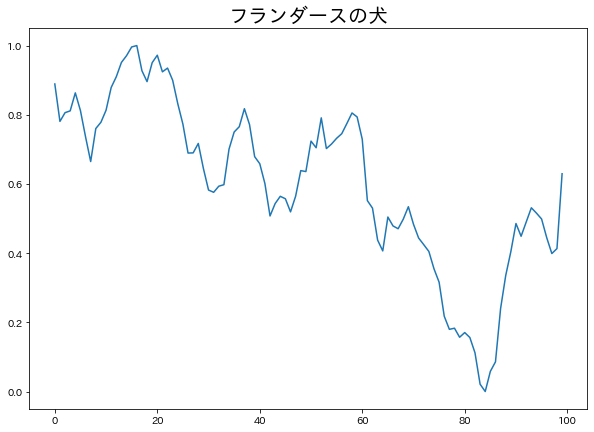

In [24]:
plt.figure(figsize=(10, 7))
plt.title(df.iloc[TARGET_DIC['id']]['作品名'], fontsize=20)
plt.plot(logit_score_norm)